In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder ,LabelEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
import joblib

In [49]:
df = pd.read_csv("../datasets/processed/BankChurners_cleaned.csv")
df.columns

Index(['Unnamed: 0', 'IDs', 'Churn', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [50]:
target = df['Churn']
df= df.drop(columns=['IDs','Churn','Unnamed: 0'])
df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  int64  
 1   Gender                    10127 non-null  object 
 2   Dependent_count           10127 non-null  int64  
 3   Education_Level           10127 non-null  object 
 4   Marital_Status            10127 non-null  object 
 5   Income_Category           10127 non-null  object 
 6   Card_Category             10127 non-null  object 
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

## Feature Engineering

In [52]:
def new_features(data):
    data['Tenure_Age_ratio'] = data['Months_on_book'] /(data['Customer_Age'] *12)
    data['Credit_Age_ratio'] = data['Credit_Limit'] /(data['Customer_Age']*12)
    data['Utilization_per_Age'] = data['Avg_Utilization_Ratio'] /(data['Customer_Age']*12)
    
    data['Amount_per_credit'] = data['Total_Trans_Amt'] /(data['Credit_Limit'])
    data['Amount_count_per_credit'] = data['Total_Trans_Ct'] /(data['Credit_Limit'])
    
    return data
    
    

df = new_features(df)

In [53]:
cols = pd.concat([target,df[['Tenure_Age_ratio','Credit_Age_ratio','Utilization_per_Age',
                     'Amount_per_credit','Amount_count_per_credit']]],axis=1)
cols.corr()['Churn'].sort_values()

Utilization_per_Age       -0.171645
Amount_per_credit         -0.133222
Amount_count_per_credit   -0.132511
Credit_Age_ratio          -0.029887
Tenure_Age_ratio           0.000465
Churn                      1.000000
Name: Churn, dtype: float64

In [54]:
num_features = df.select_dtypes(exclude=['object']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

X = df[num_features + cat_features]
y= target

X_train, X_valid ,y_train , y_valid = train_test_split(X,y,test_size=0.2, random_state=42)
print('Train Shape',X_train.shape,y_train.shape)
print('Valid Shape',X_valid.shape,y_valid.shape)

Train Shape (8101, 24) (8101,)
Valid Shape (2026, 24) (2026,)


In [55]:
encode = OneHotEncoder(handle_unknown='ignore')
scale = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('num',scale,num_features),
    ('cat',encode,cat_features)
])

pipeline= Pipeline(steps=[
      ('preprocessor',preprocessor)             
])

In [56]:
X_train_processed = pipeline.fit_transform(X_train)
X_valid_processed = pipeline.transform(X_valid)
#save the pipeline
joblib.dump(pipeline,'../models/preprocess_pipeline.pkl')

['../models/preprocess_pipeline.pkl']

## Models

In [57]:
def gridSearch(model,param,X_train,y_train):
    grid = GridSearchCV(model,param,cv=5,scoring='f1',n_jobs=-1,verbose=1)

    grid.fit(X_train,y_train)
    return grid.best_estimator_, grid.best_params_ , grid.best_score_

### LogisticRegression

In [58]:
log_param= {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced', None]}
log_model = LogisticRegression(random_state = 42) 

# best_estimator, best_param,best_score = gridSearch(log_model,log_param,X_train_processed,y_train)
# print(f"Best Estimator :  {best_estimator}")
# print(f"Best Parameters :  {best_param}")
# print(f"Best Score :  {best_score}")

**Best Logistic Regression Parameters:**

C=100 | class_weight=None | max_iter=100 | penalty='l2' | solver='newton-cg'

**Best Score:** 0.671

Grid Search Details: Fitting 5 folds for each of 270 candidates, totalling 1350 fits

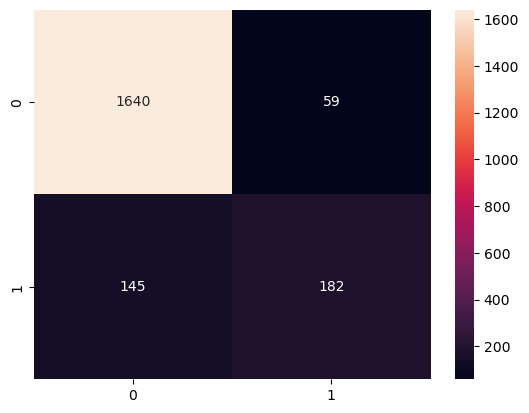

Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1699
           1       0.76      0.56      0.64       327

    accuracy                           0.90      2026
   macro avg       0.84      0.76      0.79      2026
weighted avg       0.89      0.90      0.89      2026



In [59]:
log_model = LogisticRegression(C=100,
                              class_weight=None,
                              max_iter= 100,
                              penalty='l2',
                              solver='newton-cg',
                              random_state=42)

log_model.fit(X_train_processed,y_train)
log_y_pred = log_model.predict(X_valid_processed)

cm = confusion_matrix(y_valid,log_y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.show()
print("Classification Report :\n",classification_report(y_valid,log_y_pred))

### RandomForest

In [60]:
rf_param = {
    'n_estimators': [300, 500,800],
    'max_depth': [None, 5,10,20],
    'min_samples_split': [2,3,5],
    'min_samples_leaf': [1, 2,3],
}

rf_model = RandomForestClassifier(random_state=42)
# best_estimator, best_param,best_score = gridSearch(rf_model,rf_param,X_train_processed,y_train)
# print(f"Best Estimator :  {best_estimator}")
# print(f"Best Parameters :  {best_param}")
# print(f"Best Score :  {best_score}")


**Best Random Forest Parameters:**

max_depth=None | min_samples_leaf=1 | min_samples_split=2 | n_estimators=300

**Best Score:** 0.8460

Fitting 5 folds for each of 108 candidates, totalling 540 fits

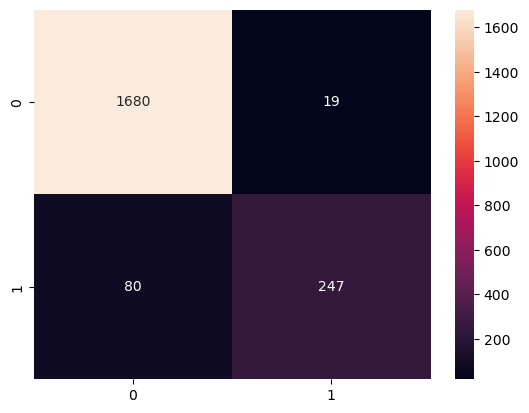

Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1699
           1       0.93      0.76      0.83       327

    accuracy                           0.95      2026
   macro avg       0.94      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026



In [61]:
rf_model = RandomForestClassifier(
    n_estimators= 300,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf = 1,
    random_state=42
)
rf_model.fit(X_train_processed,y_train)
rf_y_pred = rf_model.predict(X_valid_processed)
cm = confusion_matrix(y_valid,rf_y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.show()
print("Classification Report :\n",classification_report(y_valid,rf_y_pred))

### XGB

In [62]:
xgb_param ={
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.1,0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]

}
xgb_model = XGBClassifier(random_state=42,eval_metric='logloss')
# best_estimator, best_param,best_score = gridSearch(xgb_model,xgb_param,X_train_processed,y_train)
# print(f"Best Estimator :  {best_estimator}")
# print(f"Best Parameters :  {best_param}")
# print(f"Best Score :  {best_score}")

**Best Parameters:**
learning_rate=0.1 | max_depth=3 | n_estimators=300 | subsample=0.8 | colsample_bytree=1.0

**Best Score (ROC AUC):**
0.921

The best parameters were selected using 5-fold GridSearchCV over 144 candidates (720 fits) and applied directly to the XGB classifier.

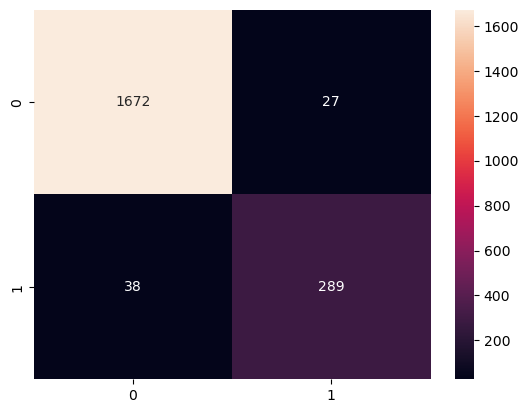

Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.91      0.88      0.90       327

    accuracy                           0.97      2026
   macro avg       0.95      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



In [64]:
xgb_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=1.0,
    eval_metric='logloss',
    random_state=42)
xgb_model.fit(X_train_processed,y_train)
xgb_y_pred = xgb_model.predict(X_valid_processed)
cm = confusion_matrix(y_valid,xgb_y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.show()
print("Classification Report :\n",classification_report(y_valid,xgb_y_pred))

The **XGBoost model** performed the best with **97% accuracy** and an **F1-score of 0.90**.


In [65]:
joblib.dump(xgb_model,'../models/best_model.pkl')

['../models/best_model.pkl']